<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/New_Test_EE_%2B_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1: Import Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import Image

print("completed")

completed


Cell 2: Load and Select Columns

In [60]:
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated',
    'vehicleType', 'fuelType', 'notRepairedDamage'  # Added features
]
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)
print("5 dòng đầu tiên của dataset:")
print(data.head())
print("\nThông tin dataset:")
print(data.info())

5 dòng đầu tiên của dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  
0  2016-03-24 00:00:00  
1  2016-03-24 00:00:00  
2  2016-03-1

Cell 3: Data Preprocessing

This cell handles missing values, caps outliers, and normalizes numerical features.

In [61]:
# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')
data['vehicleType'] = data['vehicleType'].fillna('unknown')
data['fuelType'] = data['fuelType'].fillna('unknown')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('nein')

# Feature engineering
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data['powerPS_per_km'] = data['powerPS'] / (data['kilometer'] + 1)  # Avoid division by zero
data['age_km_interaction'] = data['car_age'] * data['kilometer']
data['is_damaged'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0})
data = data.drop(columns=['dateCreated', 'yearOfRegistration', 'notRepairedDamage'])

# Ensure categorical columns are strings
for col in ['brand', 'model', 'gearbox', 'vehicleType', 'fuelType']:
    data[col] = data[col].astype(str)

# Dummies for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'], prefix='gearbox')
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model', 'vehicleType', 'fuelType']]

# Filter price > 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Scale numeric features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Scale price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

print("\n5 dòng đầu tiên sau khi xử lý:")
print(data.head())
print("\nThông tin dataset sau xử lý:")
print(data.info())

Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0


<ipython-input-61-e6ba9b7879fc>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
<ipython-input-61-e6ba9b7879fc>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
<ipython-input-61-e6ba9b7879fc>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

5 dòng đầu tiên sau khi xử lý:
      price vehicleType   powerPS    model  kilometer  monthOfRegistration  \
0  0.010168     unknown  0.203390     golf   1.000000             0.454545   
1  0.499863       coupe  0.491525  unknown   0.827586             0.363636   
2  0.266282         suv  0.400000    grand   0.827586             0.636364   
3  0.038197  kleinwagen  0.101695     golf   1.000000             0.454545   
4  0.095905  kleinwagen  0.081356    fabia   0.586207             0.545455   

  fuelType       brand  adYear   car_age  powerPS_per_km  age_km_interaction  \
0   benzin  volkswagen     1.0  0.641026        0.000199            0.406100   
1   diesel        audi     1.0  0.179487        0.000435            0.394837   
2   diesel        jeep     1.0  0.358974        0.000373            0.398325   
3   benzin  volkswagen     1.0  0.435897        0.000142            0.401316   
4   diesel       skoda     1.0  0.25

Cell 4: Train-Test Split

This cell splits the data into training, validation (tune), and test sets.

In [62]:
X = data.drop(['price'], axis=1).copy()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Tập huấn luyện có 230880 bản ghi và 15 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


Cell 5: Encode Categorical Variables for Embedding

This cell encodes categorical variables as integers for use in embedding layers.

In [63]:
input_list_train_new = []
input_list_val = []
input_list_test = []
cat_encoders = {}
for col in ['brand', 'model', 'vehicleType', 'fuelType']:  # Added vehicleType, fuelType
    unique_cat = np.unique(X_train_new[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    input_list_train_new.append(X_train_new[col].map(cat_encoders[col]).values.astype(np.int32))
    input_list_val.append(X_val[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    print(f'\nCó {len(unique_cat)} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model', 'vehicleType', 'fuelType']]
input_list_train_new.append(X_train_new[numeric_cols].values.astype(np.float32))
input_list_val.append(X_val[numeric_cols].values.astype(np.float32))
input_list_test.append(X_test[numeric_cols].values.astype(np.float32))

y_train_new = y_train_new.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 250 giá trị duy nhất trong cột model trong tập huấn luyện.

Có 9 giá trị duy nhất trong cột vehicleType trong tập huấn luyện.

Có 8 giá trị duy nhất trong cột fuelType trong tập huấn luyện.


Cell 6: Define Embedding Dimensions

This cell calculates embedding dimensions dynamically based on the number of unique categories.


Tóm tắt mô hình MLP:


Model: "Enhanced_EE_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_14            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_27 (Embedding)  │ (None, 1, 8)           │            320 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_28 (Embedding)  │ (None, 1, 15)          │          3,750 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_29 (Embedding)  │ (None, 1, 5)           │             45 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_30 (Embedding)  │ (None, 1, 4)           │             32 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_27 (Reshape)      │ (None, 8)              │              0 │ embedding_27[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_28 (Reshape)      │ (None, 15)             │              0 │ embedding_28[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_29 (Reshape)      │ (None, 5)              │              0 │ embedding_29[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_30 (Reshape)      │ (None, 4)              │              0 │ embedding_30[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_16            │ (None, 11)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 43)             │              0 │ reshape_27[0][0],      │
│ (Concatenate)             │                        │                │ reshape_28[0][0],      │
│                           │                        │                │ reshape_29[0][0],      │
│                           │                        │                │ reshape_30[0][0],      │
│                           │                        │                │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 256)            │         11,264 │ concatenate_9[0][0]    │
├──────────────────────

 Total params: 60,468 (236.20 KB)

 Trainable params: 59,572 (232.70 KB)

 Non-trainable params: 896 (3.50 KB)

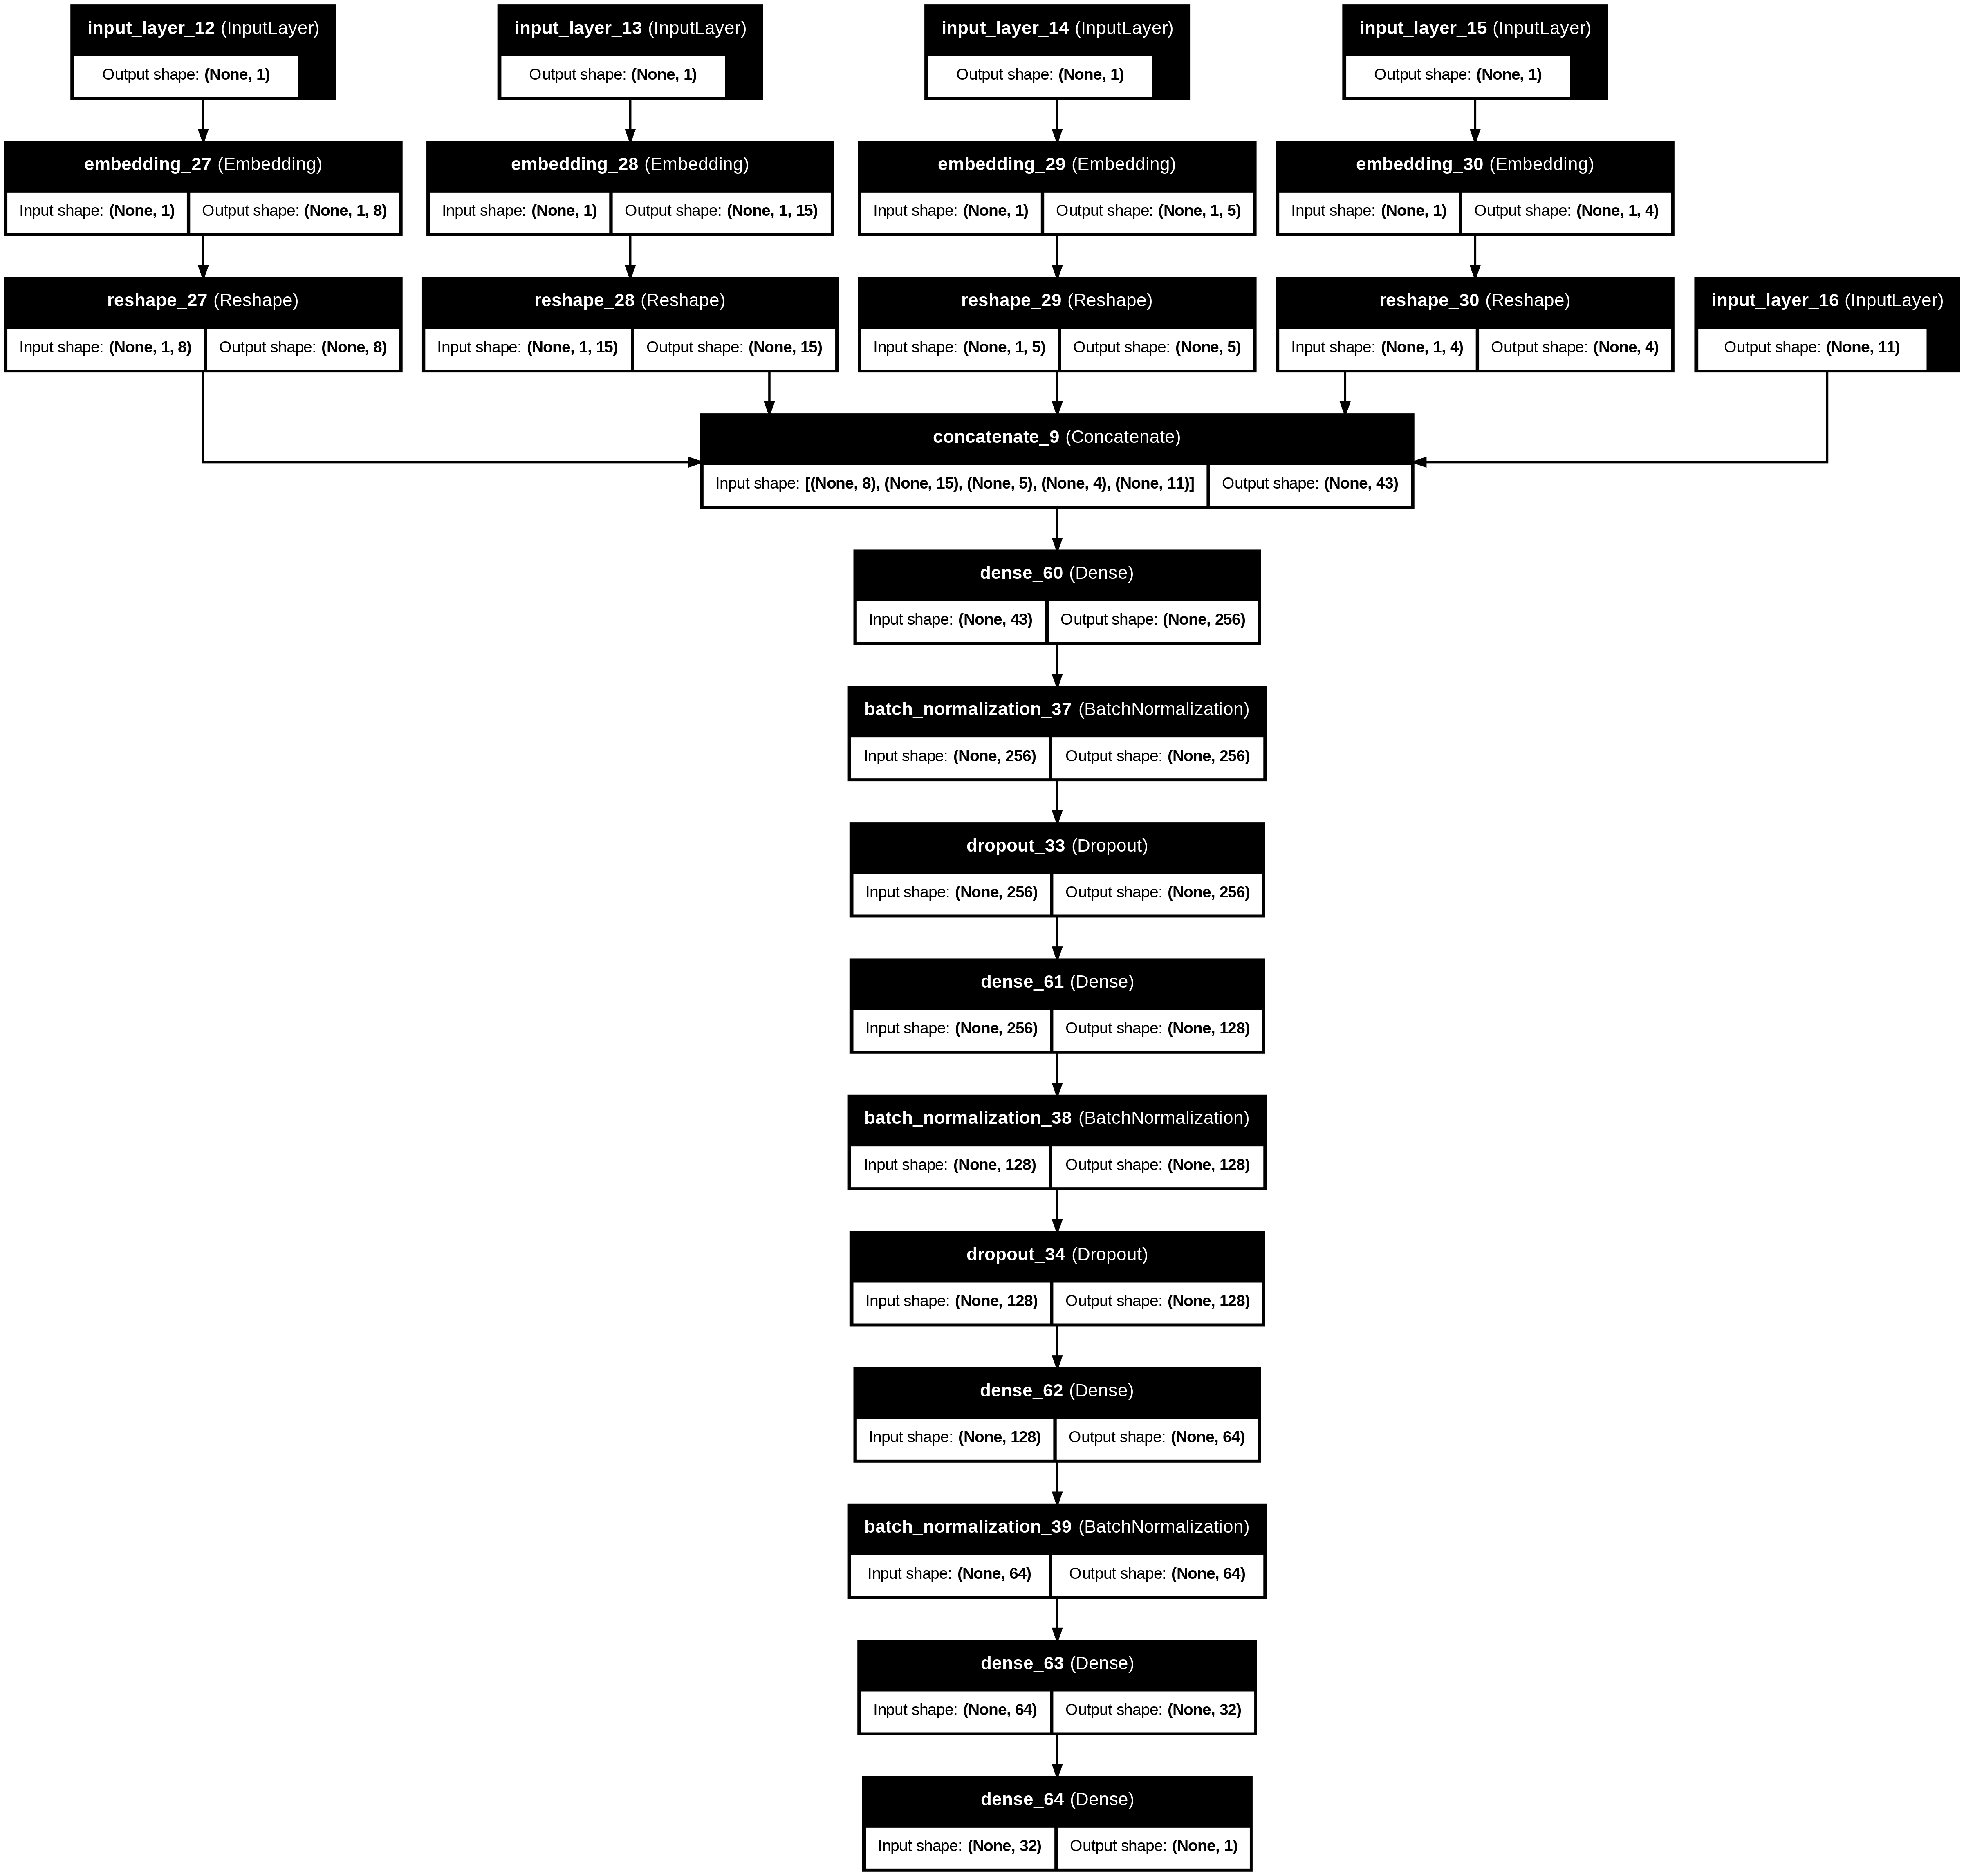

In [64]:
# Define embedding dimensions
n_unique_brand = len(np.unique(X_train_new['brand']))
n_unique_model = len(np.unique(X_train_new['model']))
n_unique_vehicleType = len(np.unique(X_train_new['vehicleType']))
n_unique_fuelType = len(np.unique(X_train_new['fuelType']))

input_brand = Input(shape=(1,))
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=8)(input_brand)  # Increased to 8
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,))
emb_model = Embedding(input_dim=n_unique_model, output_dim=15)(input_model)  # Increased to 15
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,))
emb_vehicleType = Embedding(input_dim=n_unique_vehicleType, output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,))
emb_fuelType = Embedding(input_dim=n_unique_fuelType, output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(numeric_cols),))
emb_numeric = input_numeric

input_data = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric]
emb_data = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, emb_numeric]

# Concatenate embeddings
model_data = Concatenate()(emb_data)

# Deeper MLP with residual connections
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(model_data)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
outputs = Dense(1, activation='sigmoid')(x)  # Sigmoid to enforce 0–1 range

nn = Model(inputs=input_data, outputs=outputs, name='Enhanced_EE_MLP')
print("\nTóm tắt mô hình MLP:")
nn.summary()
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Enhanced_EE_MLP.png')
Image(retina=True, filename='Enhanced_EE_MLP.png')

Cell 7: Build and Compile the MLP Model with Entity Embeddings

Epoch 1/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.4257 - mae: 0.0891 - val_loss: 0.0548 - val_mae: 0.2014 - learning_rate: 0.0020
Epoch 2/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0112 - mae: 0.0549 - val_loss: 0.0123 - val_mae: 0.0655 - learning_rate: 0.0020
Epoch 3/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0095 - mae: 0.0512 - val_loss: 0.0096 - val_mae: 0.0517 - learning_rate: 0.0020
Epoch 4/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0091 - mae: 0.0507 - val_loss: 0.0092 - val_mae: 0.0505 - learning_rate: 0.0020
Epoch 5/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0089 - mae: 0.0502 - val_loss: 0.0093 - val_mae: 0.0519 - learning_rate: 0.0020
Epoch 6/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0090 - mae: 0.0506 - val_loss: 0.0080 - val_mae: 0.0476 - learning_rate: 0.0020
Epoch 7/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0088 - mae: 0.0504 - val_loss: 0.0097 - val_mae: 0.0534 - learning_rat

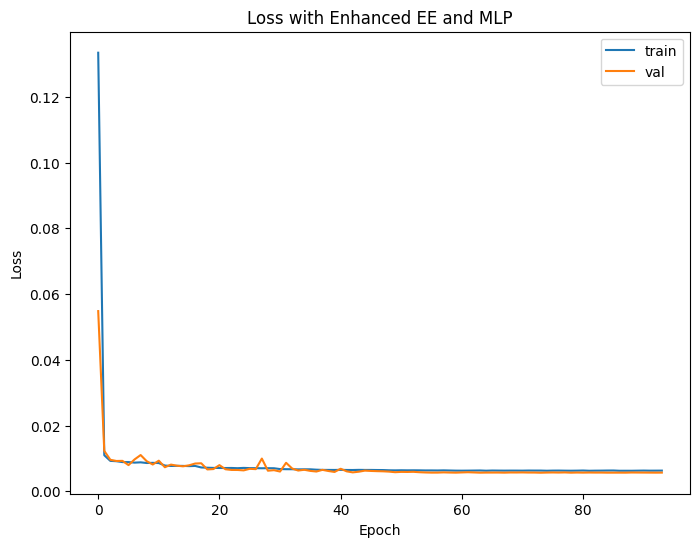

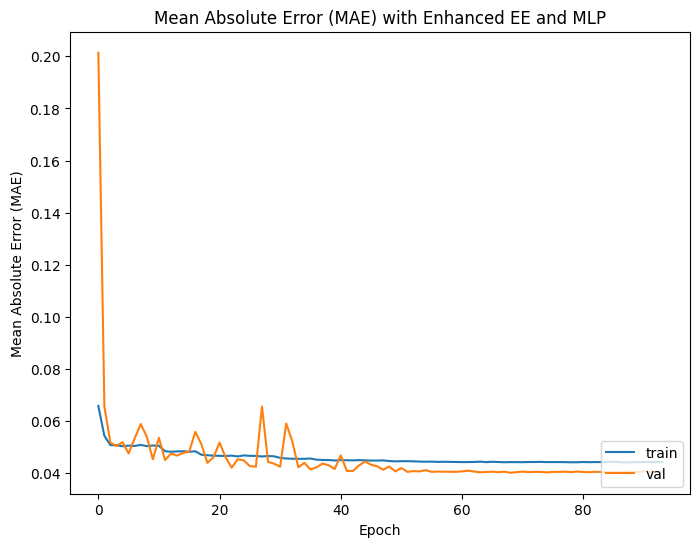

In [65]:
nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.002), metrics=['mae'])  # Increased initial LR

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-05)

history = nn.fit(
    input_list_train_new,
    y_train_new,
    validation_data=(input_list_val, y_val),
    epochs=150,  # Reduced max epochs
    batch_size=512,  # Larger batch for faster convergence
    verbose=1,
    callbacks=[es, lr_scheduler]
)

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Enhanced EE and MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with Enhanced EE and MLP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 8: Train the Model

Price Scaler Parameters in Cell 8:
data_min_: [110.]
data_max_: [36500.]
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
y_test_predict (normalized) range: 0.010530504 0.9919656
y_test (normalized) range: 0.0 1.0
y_test_predict (original scale) range: 493.20505 36207.63
y_test (original scale) range: 109.99999 36500.0
Evaluation Metrics:
                Random       Naive_Mean          MLP
MSE   314860832.891508  46713560.642554    6752608.5
RMSE      17744.318327      6834.731936  2598.578125
MAE          14719.348      4830.548835  1448.726807
R2           -5.740361        -0.000017     0.855444
MAPE        744.805475       192.844377    45.282417


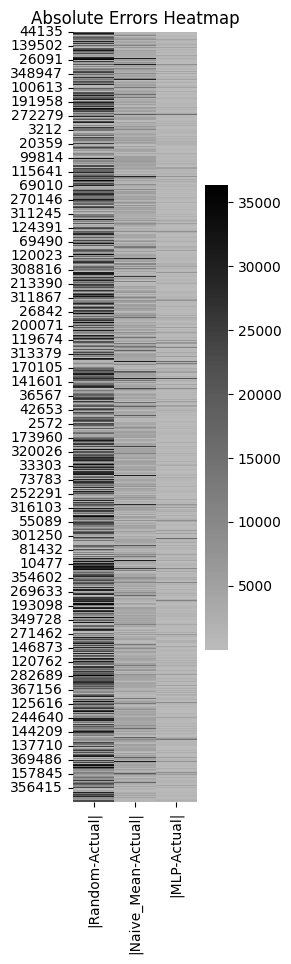

In [66]:
print("Price Scaler Parameters in Cell 8:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

y_test_predict = nn.predict(input_list_test)
print("y_test_predict (normalized) range:", y_test_predict.min(), y_test_predict.max())
print("y_test (normalized) range:", y_test.min(), y_test.max())

# Clip predictions to [0, 1] range before inverse transform
y_test_predict = np.clip(y_test_predict, 0, 1)

y_test_predict = price_scaler.inverse_transform(y_test_predict)
y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("y_test_predict (original scale) range:", y_test_predict.min(), y_test_predict.max())
print("y_test (original scale) range:", y_test.min(), y_test.max())

result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'MLP', 'Actual'])
result_df['Actual'] = y_test
result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test)).flatten()
result_df['Random'] = price_scaler.inverse_transform(np.random.uniform(y_train.min(), y_train.max(), len(y_test)).reshape(-1, 1)).flatten()
result_df['MLP'] = y_test_predict.flatten()

metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'MAE', 'R2', 'MAPE'], columns=['Random', 'Naive_Mean', 'MLP'])
n_test = len(result_df)

for m in metric_df.columns:
    metric_df.at['MSE', m] = np.sum((result_df['Actual'] - result_df[m])**2) / n_test
    metric_df.at['RMSE', m] = np.sqrt(metric_df.at['MSE', m])
    metric_df.at['MAE', m] = np.sum(abs(result_df['Actual'] - result_df[m])) / n_test
    ss_tot = np.sum((result_df['Actual'] - result_df['Actual'].mean())**2)
    ss_res = np.sum((result_df['Actual'] - result_df[m])**2)
    metric_df.at['R2', m] = 1 - ss_res / ss_tot if ss_tot != 0 else 0
    non_zero_mask = result_df['Actual'] != 0
    metric_df.at['MAPE', m] = np.sum(np.abs(result_df['Actual'][non_zero_mask] - result_df[m][non_zero_mask]) / np.maximum(result_df['Actual'][non_zero_mask], 1000)) / non_zero_mask.sum() * 100

print("Evaluation Metrics:")
print(metric_df)

for m in ['Random', 'Naive_Mean', 'MLP']:
    result_df[f'|{m}-Actual|'] = abs(result_df[m] - result_df['Actual'])

table = result_df[['|Random-Actual|', '|Naive_Mean-Actual|', '|MLP-Actual|']]
plt.figure(figsize=(2, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()

Cell 9: Evaluate the Model

In [ ]:
# # Initialize result_df
# result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'MLP', 'Actual'])
# result_df['Actual'] = price_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# # Baseline: Naive Mean
# result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test))[0]

# # Baseline: Random
# result_df['Random'] = np.random.uniform(y_train.min(), y_train.max(), y_test.shape)
# result_df['Random'] = price_scaler.inverse_transform(result_df['Random'].values.reshape(-1, 1)).flatten()

# # MLP Prediction
# y_test_predict = model.predict(input_list_test)
# result_df['MLP'] = price_scaler.inverse_transform(y_test_predict).flatten()

# # Calculate absolute differences
# for m in ['Random', 'Naive_Mean', 'MLP']:
#     result_df[f'|{m}-Actual|'] = abs(result_df[m] - result_df['Actual'])

# # Heatmap
# table = result_df[['|Random-Actual|', '|Naive_Mean-Actual|', '|MLP-Actual|']]
# plt.figure(figsize=(2, 10))
# sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
# plt.title('Absolute Errors Heatmap')
# plt.show()

# # Metrics calculation
# metric_df = pd.DataFrame(index=['ME', 'RMSE', 'MAE', 'MAPE'],
#                          columns=['Random', 'Naive_Mean', 'MLP'])
# n_test = len(result_df)

# for m in metric_df.columns:
#     metric_df.at['ME', m] = np.sum(result_df['Actual'] - result_df[m]) / n_test
#     metric_df.at['RMSE', m] = np.sqrt(np.sum((result_df['Actual'] - result_df[m])**2) / n_test)
#     metric_df.at['MAE', m] = np.sum(abs(result_df['Actual'] - result_df[m])) / n_test
#     metric_df.at['MAPE', m] = np.sum(abs(result_df['Actual'] - result_df[m]) / result_df['Actual']) / n_test * 100

# print("Evaluation Metrics:")
# print(metric_df)

Cell 10: Tune the Model

Tests different hidden layer sizes and reports RMSE on the validation set.

In [ ]:
# # Tuning hidden layer sizes
# hidden_layer_options = [(128, 64, 32), (64, 32), (256, 128, 64)]
# tune_df = pd.DataFrame(index=[str(h) for h in hidden_layer_options], columns=['RMSE'])

# for h in hidden_layer_options:
#     # Model building and training code (abridged)
#     # ...
#     y_tune_predict = model.predict(input_list_tune)
#     rmse = np.sqrt(np.mean((price_scaler.inverse_transform(y_tune_predict) -
#                             price_scaler.inverse_transform(y_tune.values.reshape(-1, 1)))**2))
#     tune_df.at[str(h), 'RMSE'] = rmse

# print("Tuning Results:")
# print(tune_df.sort_values('RMSE'))